# Make All Figures for Main Manuscript

Kendra Wyant  
January 27, 2025

In [ ]:
#| message: false
#| warning: false

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(patchwork)

theme_set(theme_classic())

path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_shared <- format_path("studydata/risk/data_processed/shared")
path_processed <- format_path("studydata/risk/data_processed/lag")

Data for figures

In [ ]:
test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag,
                                                "pp_perf_tibble.csv"),
                                     show_col_types = FALSE)

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"),
                            show_col_types = FALSE)

global_all <- read_rds(here::here(path_models_lag, "shap_global_all.rds")) |> 
   filter(str_detect(variable_grp, "EMA")) |> 
   mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
          variable_grp = reorder(variable_grp, mean_value, sum),
          model = factor(model, levels = c("336 lag", "168 lag", "72 lag", "24 lag", "0 lag"),
                         labels = c("2 weeks", "1 week", "3 days", "1 day", "No lag" ))) |> 
  filter(model %in% c("2 weeks", "No lag"))

shap_levels <- global_all |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()

## Figure 1: Prediction Methods

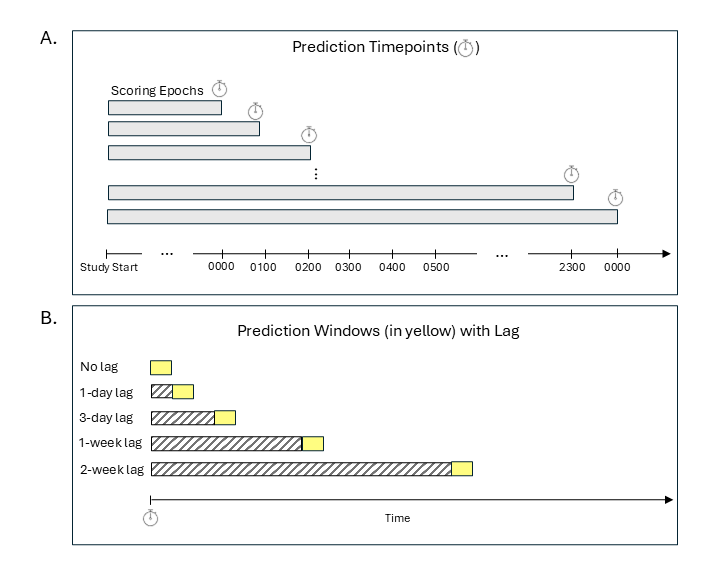

In [ ]:
#| label: fig-methods
#| fig-cap: "Panel A shows the prediction time points at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction time point was used to generate these predictions. Features were created for varying scoring epochs before the prediction time point (i.e., 12, 24, 48, 72, and 168 hours). Prediction time points were updated hourly. Panel B shows how the prediction window (i.e., window in which a lapse might occur) rolls forward hour-by-hour with the prediction time point. The prediction window width for all models was one day (24 hours). Additionally, there were five possible lag times between the prediction time point and start of the prediction window. A prediction window either started immediately after the prediction time point (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks."

knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)

## Figure 2: Posterior probability for auROC by model and demographic group differences

In [ ]:
fig_2a <- test_metrics_all_pp_perf |>
  mutate(model_numeric = case_when(model == "336 lag" ~ as.numeric(336),
                                   model == "168 lag" ~ as.numeric(168),
                                   model == "72 lag" ~ as.numeric(72),
                                   model == "24 lag" ~ as.numeric(24),
                                   model == "0 lag" ~ as.numeric(0))) |> 
  ggplot() + 
  geom_point(aes(x = model_numeric, y = pp_median), color = "black") +
  geom_line(aes(x = model_numeric, y = pp_median)) +
  geom_segment(mapping = aes(x = model_numeric, y = pp_lower, yend = pp_upper)) +
  scale_y_continuous("auROC", limits = c(.50, 1.0)) +
  scale_x_continuous("Model Lag", breaks = c(0, 24, 72, 168, 336), 
                     labels = c("No lag", "1 day", "3 days", "1 week",
                                "2 weeks")) +
  theme_classic() +
  theme(legend.position = "none",
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black")

In [ ]:
pp_dem <- pp_dem |>
  mutate(contrast = factor(model, levels = c("not white", 
                                             "non-hispanic white",
                                             "female",
                                             "male",
                                             "below poverty",
                                             "above poverty"),
                           labels = c("Not White vs. Non-Hispanic White",
                                      "Not White vs. Non-Hispanic White",
                                      "Female vs. Male",
                                      "Female vs. Male",
                                      "Below Poverty vs. Above Poverty",
                                      "Below Poverty vs. Above Poverty")),
         group = factor(model, levels = c("non-hispanic white",
                                          "not white", 
                                          "female",
                                          "male",
                                          "below poverty",
                                          "above poverty"),
                        labels = c("advantaged group (non-Hispanic White, male, above poverty)", 
                                   "disadvantaged group (not White, female, below poverty)",
                                   "disadvantaged group (not White, female, below poverty)",
                                   "advantaged group (non-Hispanic White, male, above poverty)",
                                   "disadvantaged group (not White, female, below poverty)",
                                   "advantaged group (non-Hispanic White, male, above poverty)"))) 

pp_dem_a <- pp_dem |> 
  filter(contrast == "Not White vs. Non-Hispanic White" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Race/Ethnicity") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous("auROC", limits = c(.35, 1.0)) +
  scale_x_discrete(NULL, labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

pp_dem_b <- pp_dem |> 
  filter(contrast == "Female vs. Male" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Sex at birth") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous(NULL, limits = c(.35, 1.0)) +
  scale_x_discrete("Model Lag", labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

pp_dem_c <- pp_dem |> 
  filter(contrast == "Below Poverty vs. Above Poverty" & lag %in% c(0, 336)) |> 
  mutate(lag = factor(lag),
         contrast = "Income") |> 
  ggplot() + 
  geom_point(aes(x = lag, y = pp_median, color = group)) +
  geom_segment(mapping = aes(x = lag, y = pp_lower, yend = pp_upper, color = group)) +
  facet_wrap(~ contrast) +
  scale_y_continuous(NULL, limits = c(.35, 1.0)) +
  scale_x_discrete(NULL, labels = c("No lag", "2 weeks")) +
  theme_classic() +
  theme(panel.border = element_rect(colour = "black", fill = NA, linewidth = 1)) +
  scale_color_manual(values = c("#240e31", "#cb6bce")) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  labs(color = NULL)

fig_2b <- pp_dem_a + pp_dem_b + pp_dem_c + plot_layout(guides = "collect") &
  theme(legend.position = "bottom", legend.direction = "vertical") 

fig_2 <- (fig_2a / fig_2b) &
  plot_annotation(tag_levels = "A")

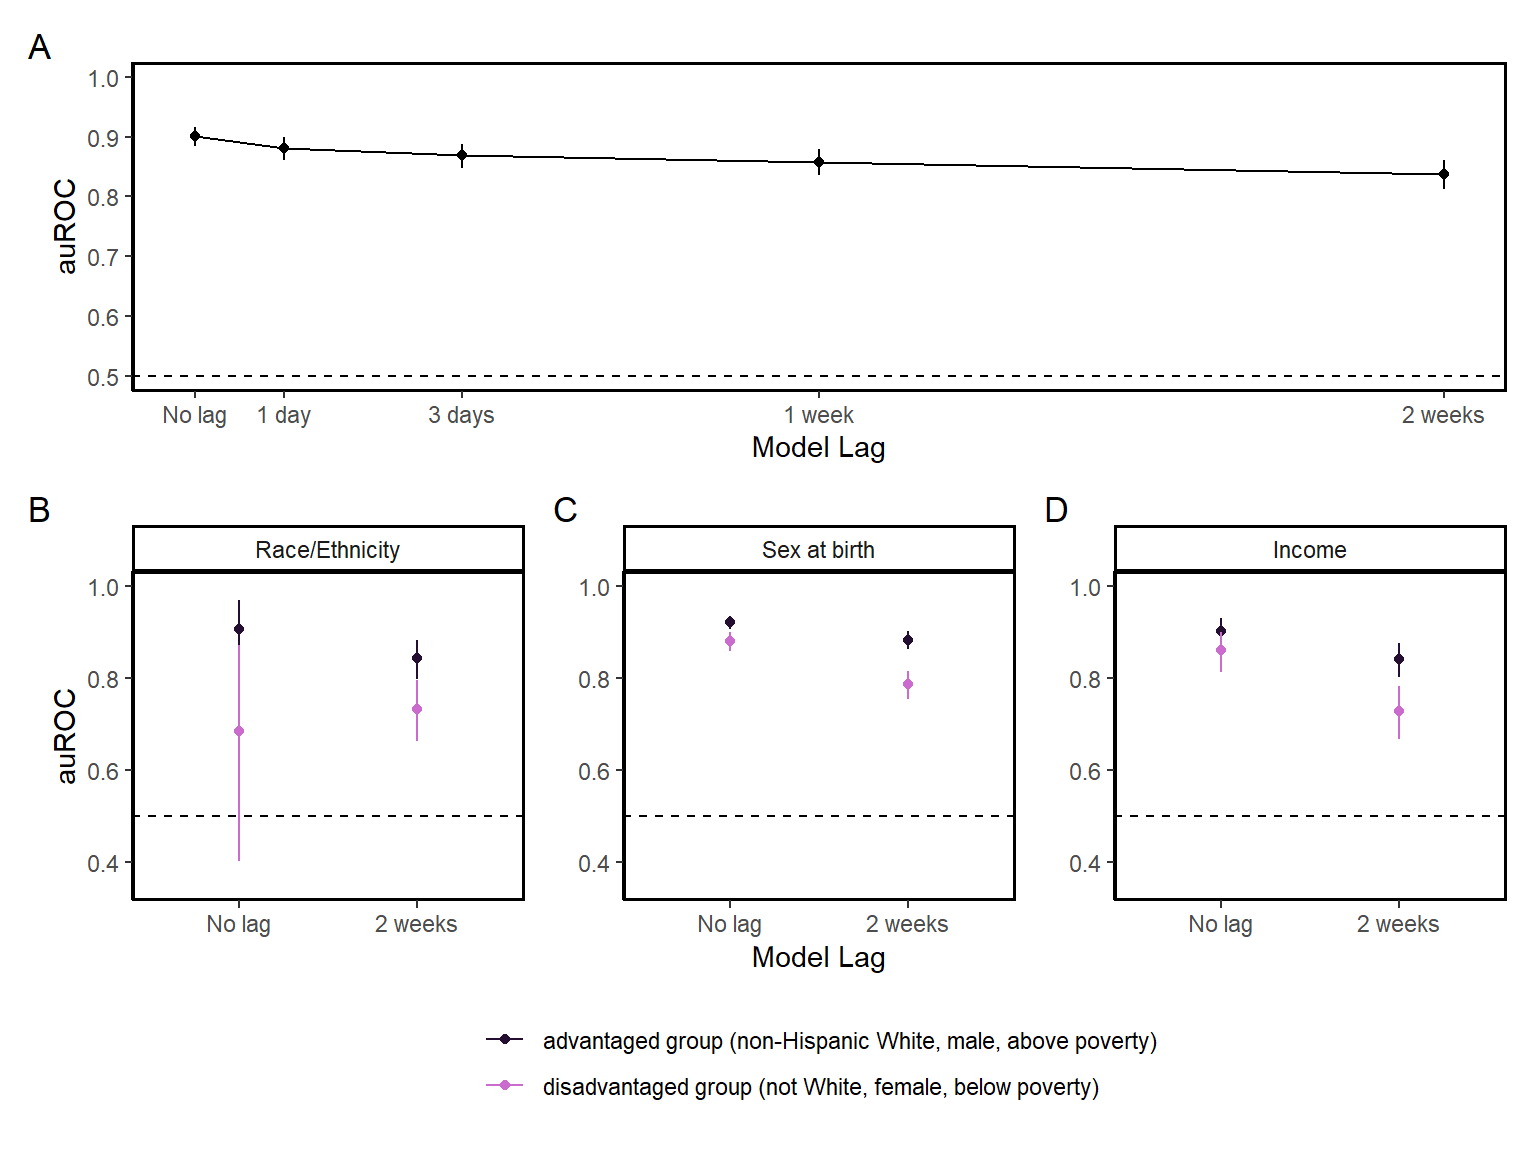

In [ ]:
#| label: fig-2
#| fig-cap: "Panel A displays the median posterior probability for area under ROC curve (auROC) and 95% Bayesian CI for each lagged model (0, 1-day, 3-day, 1-week, and 2-week lag). Dashed line represents a random classifier with an auROC of .5. Panels B-D display the median auROC and Bayesian credible interval for the 0 and 2-week lag models by fairness contrast. The darker lines represent the advantaged groups (non-Hispanic White, male, above poverty) and the lighter lines represent the disadvantaged groups (not White, female, below poverty). Dashed lines represent a random classifier with an auROC of .5."
#| fig-width: 8
#| fig-height: 6

fig_2 

## Figure 3: Global and Local Shapley Plots

In [ ]:
global_panel <- global_all |>
  ggplot() +
  geom_bar(aes(x = variable_grp, y = mean_value, fill = model), 
           stat = "identity", position = "dodge") +
  labs(y = "Mean(|Shapley Value|)",
       x = NULL,
       fill = NULL) +
  scale_fill_manual(values = c("#458892", "#751c6d")) +
  theme(axis.text=element_text(size=9.5),
        legend.key.size = unit(0.25, "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
        legend.position = "right") +
  coord_flip()

In [ ]:
shap_feat_0 <- read_rds(here::here(path_models_lag, 
                                   "outer_shapsgrp_1day_0_v3_nested_main.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels)) |> 
  group_by(variable_grp) |> 
  summarize(min(value), max(value)) |> 
  mutate(model = "No lag")

shap_feat_336 <- read_rds(here::here(path_models_lag, 
                                     "outer_shapsgrp_1day_336_v3_nested_main.rds")) |> 
  filter(str_detect(variable_grp, "EMA")) |> 
  mutate(variable_grp = str_remove(variable_grp, "\\(EMA item\\)"),
         variable_grp = factor(variable_grp, levels = shap_levels))  |> 
  group_by(variable_grp) |> 
  summarize(min(value), max(value)) |> 
  mutate(model = "2 weeks")

panel_shap_local <- shap_feat_0 |>
  bind_rows(shap_feat_336) |> 
  mutate(model = factor(model, levels = c("2 weeks", "No lag"))) |> 
  rename(min = `min(value)`,
         max = `max(value)`) |> 
  ggplot() +
  geom_segment(aes(x = variable_grp, y = min, yend = max, group = model,
                   color = model),
               position = position_dodge(width = .5)) +
  ylab("Raw Shapley Value") +
  xlab(NULL) +
  labs(color = NULL) +
  scale_color_manual(values = c("#458892", "#751c6d")) +
  theme(legend.position = "none",
        axis.text=element_text(size=9.5),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))+
  coord_flip()

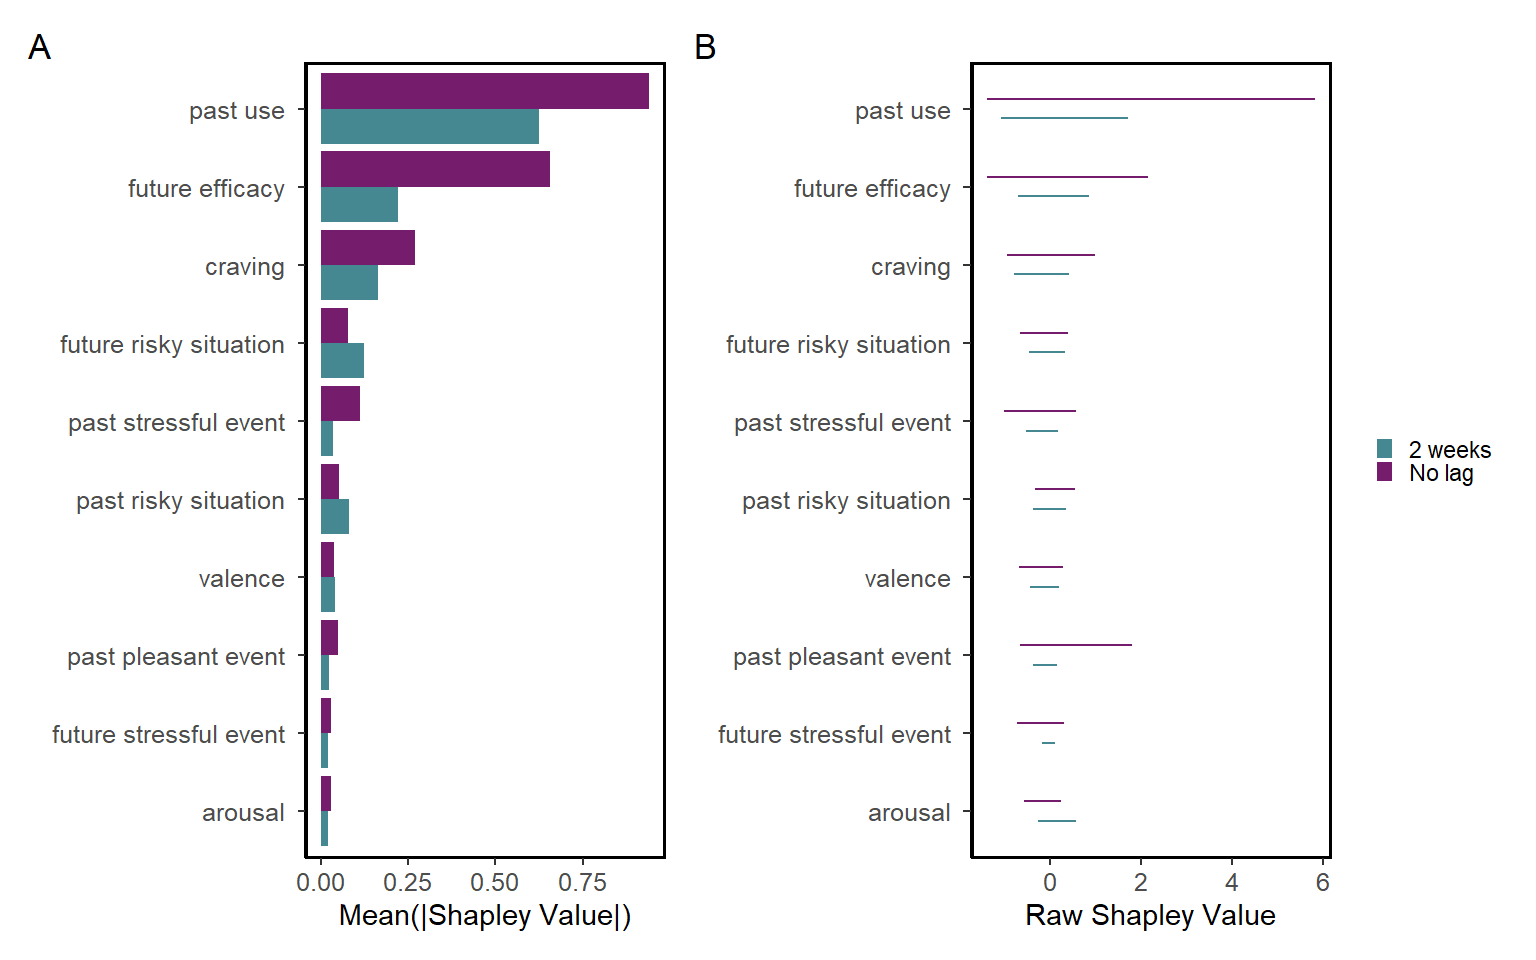

In [ ]:
#| label: fig-3
#| fig-cap: "Panel A displays the global importance (mean |Shapley value|) for feature categories for the no lag and 2-week lag models. Feature categories are ordered by their aggregate global importance. The importance of each feature category for each model is displayed separately by color. Panels B displays the variation (min and max Shapley values) in local feature importance for the no lag and 2-week lag models."
#| fig-width: 8
#| fig-height: 5

global_panel + panel_shap_local + 
  plot_layout(guides = "collect") &
  plot_annotation(tag_levels = "A") 